# Vehicle Detection

This note book describes step by step of doing vehicle detection by using a combination of Histogram of Oriented Gradients (HOG) and Sliding Window Search techniques

### Import Dependencies

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import pickle
import pprint

%matplotlib inline

print('Dependencies importing done!')

Dependencies importing done!


### Load and Visualize Training Data

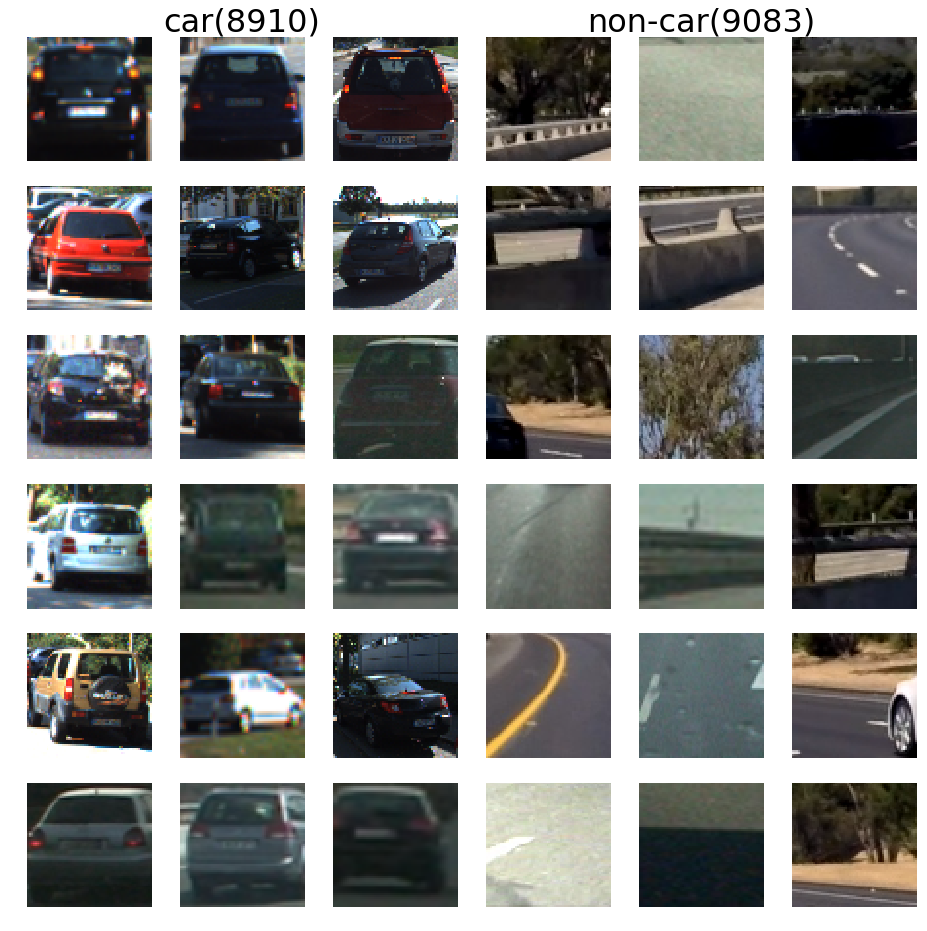

In [2]:
car_images = glob.glob('labeled_images/vehicles/*/*.png')
car_images.extend(glob.glob('labeled_images/vehicles/*/*.jpg'))
noncar_images = glob.glob('labeled_images/non-vehicles/*/*.png')
noncar_images.extend(glob.glob('labeled_images/non-vehicles/*/*.jpg'))

fig, axs = plt.subplots(6,6, figsize=(16, 16))

# Step through the list and search for chessboard corners
for r in range(6):
    for c in range(3):
        img = cv2.imread(np.random.choice(car_images))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[r][c].axis('off')
        if r==0 and c==1:
            axs[r][c].set_title('car({})'.format(len(car_images)), fontsize=32)
        axs[r][c].imshow(img)
    for c in range(3,6):
        img = cv2.imread(np.random.choice(noncar_images))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[r][c].axis('off')
        if r==0 and c==4:
            axs[r][c].set_title('non-car({})'.format(len(noncar_images)), fontsize=32)
        axs[r][c].imshow(img)
plt.savefig('./output_images/peep_dataset.png')

## Histogram of Oriented Gradients (HOG)

### Function Definition

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features



# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        #image = mpimg.imread(file)
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

def extract_all_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                         spatial=32, hist_bins=32):
    hog_features = extract_features(imgs, cspace, orient, pix_per_cell, cell_per_block, hog_channel)
    color_features = extract_color_features(imgs, cspace, (spatial, spatial), hist_bins, hist_range=(0,256))
    features = np.hstack((hog_features, color_features))
    return features


### Train Classifer

In [4]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### Parameters Tunning
spatial = 16
histbin = 32
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 16
cell_per_block = 3
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
#car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
#                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                        hog_channel=hog_channel)
car_features = extract_all_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial=spatial, hist_bins=histbin)
#notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
#                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                        hog_channel=hog_channel)
notcar_features = extract_all_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial=spatial, hist_bins=histbin)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))



127.26 Seconds to extract HOG features...
Using: 12 orientations 16 pixels per cell and 3 cells per block
Feature vector length: 2160


In [5]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

#save model
print('Saving Classifier...')
filename = r'.\trained_classifer.sav'
pickle.dump(svc, open(filename, 'wb'))
print('Trained classifier is saved at {}'.format(filename))

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

9.7 Seconds to train SVC...
Saving Classifier...
Trained classifier is saved at .\trained_classifer.sav
Test Accuracy of SVC =  0.9853
My SVC predicts:  [1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
For these 10 labels:  [1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
0.01702 Seconds to predict 10 labels with SVC


## Check point -- load trained model

In [6]:
print('Loading Classifier...')
filename = r'.\trained_classifer.sav'
svc = pickle.load(open(filename, 'rb'))
print('Trained classifier is loaded.')

Loading Classifier...
Trained classifier is loaded.


In [7]:
captured_car_images = glob.glob('test_images/car*.png')
captured_car_features = extract_all_features(captured_car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial=spatial, hist_bins=histbin)

X_car = np.array(captured_car_features).astype(np.float64)
X_car = X_scaler.transform(X_car)
result = svc.predict(X_car)
print(result)

[0. 0. 1. 1. 1.]


## Finding Cars

### Function Definition

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched 
    range_x = x_start_stop[1] - x_start_stop[0]
    range_y = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    step_x = xy_window[0] - int(xy_window[0] * xy_overlap[0])
    step_y = xy_window[1] - int(xy_window[1] * xy_overlap[1])
    # Compute the number of windows in x/y
    num_x = (range_x-int(xy_window[0] * xy_overlap[0]))/step_x
    num_y = (range_y-int(xy_window[1] * xy_overlap[1]))/step_y
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for x in range(x_start_stop[0], x_start_stop[1]-xy_window[0]+1, step_x):
        for y in range(y_start_stop[0], y_start_stop[1]-xy_window[1]+1, step_y):
            window_list.append(((x,y),(x+xy_window[0], y+xy_window[1])))
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list


def resize_img_and_win(img, window_list, standar_win_size = (64,64)):
    x_scale = (window_list[0][1][0] - window_list[0][0][0])/standar_win_size[0]
    y_scale = (window_list[0][1][1] - window_list[0][0][1])/standar_win_size[1]
    output_img = cv2.resize(img, (np.int(img.shape[1]/x_scale), np.int(img.shape[0]/y_scale)))
    output_win_list = []
    for win in window_list:
        top_left_x = np.int(win[0][0]/x_scale)
        top_left_y = np.int(win[0][1]/y_scale)
        output_win_list.append(((top_left_x, top_left_y),(top_left_x + standar_win_size[0], top_left_y + standar_win_size[1])))
    return output_img, output_win_list

def sample_list(input_list, sample_rate):
    if sample_rate < 1:
        sample_num = int(len(input_list)*sample_rate)
    else:
        sample_num = int(sample_rate)
    choice_index = np.random.choice(len(input_list), size=sample_num)
    output_list = []
    for i in choice_index:
        output_list.append(input_list[i])
    return output_list

def get_windows_list(img):
    global search_param
    windows_list = []
    for i in range(len(search_param)):
        windows = slide_window(image, x_start_stop= search_param[i][0], y_start_stop=search_param[i][1], 
                                xy_window=search_param[i][2], xy_overlap=(0.7, 0.7))
        windows_list.append(windows)
    return windows_list
count = 1
def extract_windows_features(image, windows, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    global count
    # Create a list to append feature vectors to
    features = []

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=False
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            feat = get_hog_features(feature_image[:,:,channel], orient, 
                                    pix_per_cell, cell_per_block, vis=False, feature_vec=False)
            hog_features.append(feat)
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    for win in windows:
        out_img = image[win[0][1]:win[0][1]+64, win[0][0]:win[0][0]+64]
        #cv2.imwrite(r'temp\{}_{}_{}.png'.format(count, str(image.shape[:2]), str(win)), out_img)
        #print(r'temp\{}.png'.format(count))
        count += 1
        start_block_x = win[0][0] // pix_per_cell
        start_block_y = win[0][1] // pix_per_cell
        if hog_channel == 'ALL':
            win_hog_features = []
            for feat in hog_features:
                win_feat = retrieve_win_feature(feat, win, pix_per_cell, cell_per_block)
                win_hog_features.append(win_feat)
            win_hog_features = np.ravel(win_hog_features)
        else:
            win_hog_features = retrieve_win_feature(hog_features, win, pix_per_cell, cell_per_block)
        # Append the new feature vector to the features list
        features.append(win_hog_features)   

    # Return list of feature vectors
    return features

def retrieve_win_feature(full_feature, window, pix_per_cell, cell_per_block):
    assert window[1][0]-window[0][0] == window[1][1]-window[0][1] # width == height
    win_size = window[1][0]-window[0][0]
    nblock_per_window = (win_size//pix_per_cell) + 1 - cell_per_block
    start_block_x = window[0][0] // pix_per_cell
    if start_block_x > full_feature.shape[1]:
        start_block_x = full_feature.shape[1]
    start_block_y = window[0][1] // pix_per_cell
    if start_block_y > full_feature.shape[0]:
        start_block_y = full_feature.shape[0]
    win_feature = full_feature[start_block_y:start_block_y+nblock_per_window, start_block_x:start_block_x+nblock_per_window]
    win_feature = win_feature.ravel()
    return win_feature


def get_car_windows(img, search_windows, classifier):
    """
    search_windows is a list of rect which has the same size
    """
    global pix_per_cell
    global colorspace
    global orient
    global cell_per_block
    global hog_channel
    global X_scaler
    resized_img, resized_windows = resize_img_and_win(image, search_windows, standar_win_size = (64,64))
    windows_features = extract_windows_features(resized_img, resized_windows, cspace=colorspace, orient=orient, 
                                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                                hog_channel=hog_channel)
    car_windows = []
    X_features = np.array(windows_features).astype(np.float64)
    X_features = X_scaler.transform(X_features)
    classify_results = classifier.predict(X_features)
    for i in range(len(classify_results)):
        if classify_results[i]:
            car_windows.append(search_windows[i])
    #pp = pprint.PrettyPrinter()
    #pp.pprint(car_windows)
    return car_windows

def find_cars(img):
    global svc
    car_windows = []
    variant_scale_windows = get_windows_list(img)
    for windows in variant_scale_windows:
        car_windows.extend(get_car_windows(img, windows, svc))
    return car_windows


### Function Testing: resize_img_and_win()

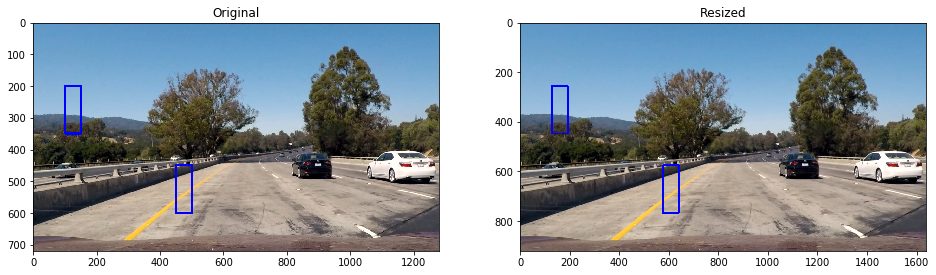

In [9]:
image = mpimg.imread(r'test_images\test1.jpg')

windows = [((100, 200),(150, 350)), ((450, 450),(500,600))]
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)     

resized_img, resized_windows = resize_img_and_win(image, windows, standar_win_size = (64,192))
resized_win_img = draw_boxes(resized_img, resized_windows, color=(0, 0, 255), thick=6)  

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 16))
ax1.imshow(window_img)
ax1.set_title('Original')
ax2.imshow(resized_win_img)
ax2.set_title('Resized')

### Search area and window size tunning

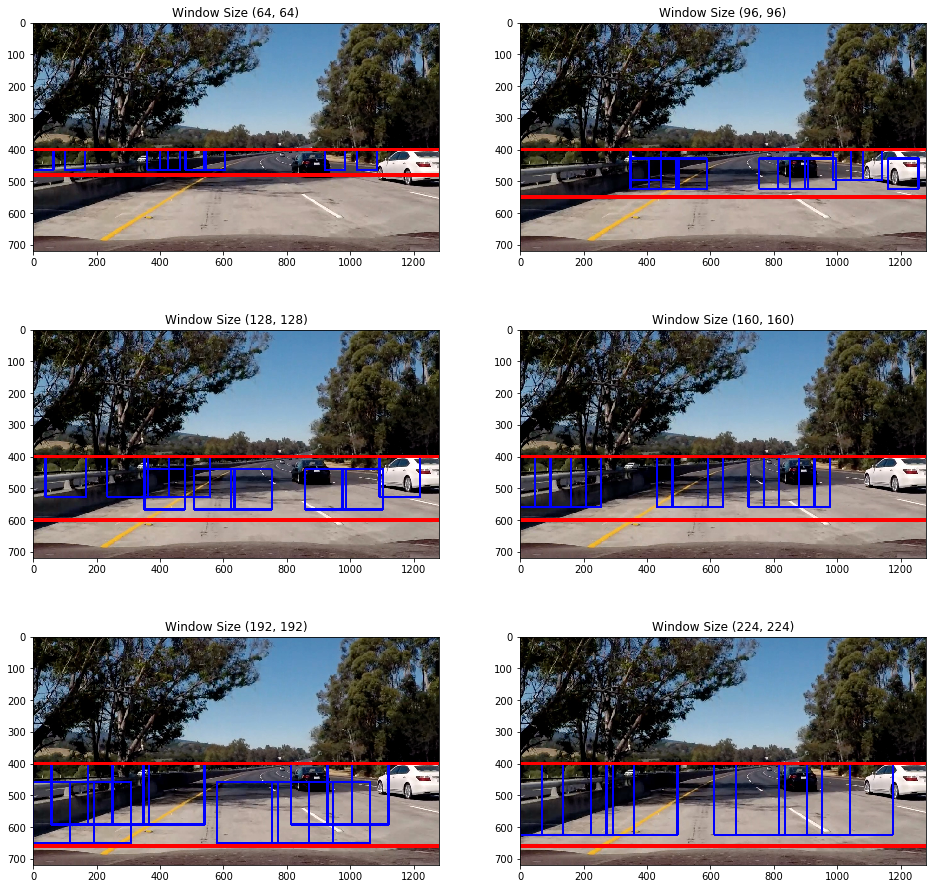

In [10]:
# Define search area with corresponding window size
# in format: (x_start_stop, y_start_stop, window_size)
search_param = [
    ([0, None], [400, 480], (64, 64)),
    #([0, None], [350, 500], (80, 80)),
    ([0, None], [400, 550], (96, 96)),
    #([0, None], [400, 600], (112, 112)),
    ([0, None], [400, 600], (128, 128)),
    #([0, None], [400, None], (144, 144)),
    ([0, None], [400, 600], (160, 160)),
    ([0, None], [400, 660], (192, 192)),
    ([0, None], [400, 660], (224, 224)),
]

image = mpimg.imread(r'test_images\test5.jpg')
fig, axs = plt.subplots(int((len(search_param)+1)/2),2, figsize=(16, 16))
axs = axs.ravel()

# This is the windows to be tested with trained model
wins_list = get_windows_list(image)
for i in range(len(search_param)):
    sampled_win = sample_list(wins_list[i], 10)
    win_img = draw_boxes(image, sampled_win, color=(0, 0, 255), thick=6)
    range_box = [((search_param[i][0][0]-5, search_param[i][1][0]), 
                  (search_param[i][0][1]+5, search_param[i][1][1]))]
    win_img = draw_boxes(win_img, range_box, color=(255, 0, 0), thick=10)
    axs[i].imshow(win_img)
    axs[i].set_title('Window Size {}'.format(search_param[i][2]))
    


### Function Testing: find_cars()

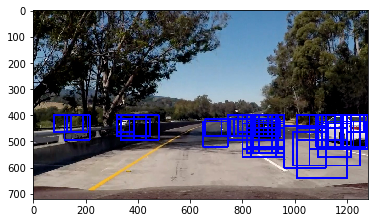

In [33]:
image = mpimg.imread(r'test_images\test5.jpg')
car_boxes = find_cars(image)
output_img = draw_boxes(image, car_boxes, color=(0, 0, 255), thick=6)
plt.imshow(output_img)

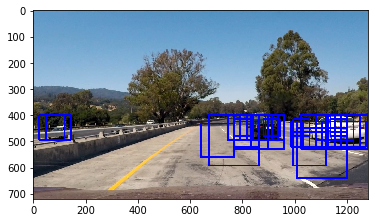

In [39]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def get_car_windows(img, ystart, ystop, scale, svc):
    global X_scaler
    global orient
    global pix_per_cell
    global cell_per_block
    global spatial
    global histbin
    
    windows = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            sav_img = cv2.cvtColor(subimg, cv2.COLOR_HSV2RGB)
            mpimg.imsave(r'temp\{}.jpg'.format(time.time()), sav_img)
            # Get color features
            spatial_features = bin_spatial(sav_img, size=(spatial, spatial))
            hist_features = color_hist(sav_img, nbins=histbin)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return windows

def find_cars(img):
    global svc
    global search_param

    car_windows = []
    for param in search_param:
        ystart = param[1][0]
        ystop = param[1][1]
        scale = param[2][0]/64
        car_windows.extend(get_car_windows(img, ystart, ystop, scale, svc))
    return car_windows

image = mpimg.imread(r'test_images\test1.jpg')
car_boxes = find_cars(image)
output_img = draw_boxes(image, car_boxes, color=(0, 0, 255), thick=6)
plt.imshow(output_img)


## Combine Multiple Detections & Remove False Positives

### Function Definition

In [28]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(heatmap):
    labeled_boxes = []
    labels = label(heatmap)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        labeled_boxes.append(bbox)
    # Return the image
    return labeled_boxes

def filter_car_boxes(image, car_boxes, thresh = 10):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    thresh_rate = thresh / len(car_boxes)
    add_boxes(car_boxes)
    car_boxes = get_pre_boxes()
    thresh = int(len(car_boxes) * thresh_rate)
    # Add heat to each box in box list
    heat = add_heat(heat,car_boxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, thresh)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labeled_bboxes = get_labeled_bboxes(heatmap)
    return labeled_bboxes, heatmap


### Function Testing

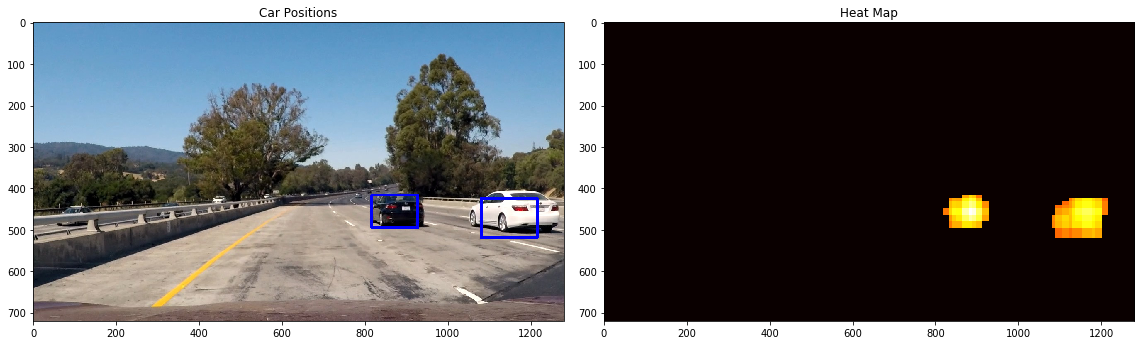

In [43]:
labeled_bboxes, heatmap = filter_car_boxes(image, car_boxes, thresh=5)
draw_img = draw_boxes(image, labeled_bboxes, color=(0, 0, 255), thick=6)

fig = plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Pipeline

In [17]:
def pipeline(input_image):
    image = np.copy(input_image)
    car_boxes = find_cars(image)
    labeled_bboxes, heatmap = filter_car_boxes(image, car_boxes, thresh=5)
    #resized_heatmap = cv2.resize(heatmap, (heatmap.shape[0]//6, heatmap.shape[1]//6))
    #resized_heatmap = np.dstack((resized_heatmap,resized_heatmap,resized_heatmap))
    output_image = draw_boxes(image, labeled_bboxes, color=(0, 0, 255), thick=6)
    #output_image[:resized_heatmap.shape[0],:resized_heatmap.shape[1],:] = resized_heatmap
    return output_image

## Test on Video

In [46]:
#test_out_file = 'test_video_out.mp4'
#clip_test = VideoFileClip('test_video.mp4')
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

OSError: [WinError 6] The handle is invalid

### Record previous frames

In [20]:
pre_frames = []
nrecords = 10
def add_boxes(car_boxes):
    global pre_frames
    global nrecords
    pre_frames.append(car_boxes)
    if len(pre_frames) > nrecords:
        pre_frames = pre_frames[-nrecords:]
        
def get_pre_boxes():
    global pre_frames
    global nrecords
    return [item for sublist in pre_frames for item in sublist]